# Federated Learning: Image Classification

Using MNIST dataset. Refer to the tutorial [here](https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification)

In this tutorial, we use the classic MNIST training example to introduce the Federated Learning (FL) API layer of TFF, tff.learning - a set of higher-level interfaces that can be used to perform common types of federated learning tasks, such as federated training, against user-supplied models implemented in TensorFlow.

[tff.learning](https://www.tensorflow.org/federated/api_docs/python/tff/learning) - Libraries for using Federated Learning algorithms.

In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
%load_ext tensorboard

In [3]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

import matplotlib.pyplot as plt

In [4]:
tff.federated_computation(lambda: 'Hello, World!')()

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


b'Hello, World!'

In [6]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.4.1


### Preparing the input data:

_Federated learning (FL) requires a federated data set, i.e., a collection of data from multiple users_. __Federated data is typically non-i.i.d. (independent and identically distributed), which poses a unique set of challenges__.

In order to facilitate FL based experimentation, Google's TFF team have provided the TFF repository with some datasets, including a federated version of MNIST that contains a version of the [original NIST dataset](https://www.nist.gov/srd/nist-special-database-19) that has been re-processed using [Leaf](https://github.com/TalwalkarLab/leaf) so that the data is keyed by the original writer of the digits.
Since each writer has a unique style, this dataset exhibits the kind of non-i.i.d. behavior expected of federated datasets.

In [7]:
# Load dataset-
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

In [8]:
type(emnist_train), type(emnist_test)

(tensorflow_federated.python.simulation.hdf5_client_data.HDF5ClientData,
 tensorflow_federated.python.simulation.hdf5_client_data.HDF5ClientData)

The data sets returned by 'load_data()' are instances of _tff.simulation.ClientData_, an interface that allows you to enumerate the set of users, to construct a 'tf.data.Dataset' that represents the data of a particular user, and to query the structure of individual elements.

Here's how you can use this interface to explore the content of the data set. Keep in mind that _while this interface allows you to iterate over clients ids, this is only a feature of the simulation data_. As you will see shortly, __client identities are not used by the federated learning framework__ - their only purpose is to allow you to select subsets of the data for simulations.

In [9]:
print(f"number of client IDs available for MNIST dataset = {len(emnist_train.client_ids)}")

number of client IDs available for MNIST dataset = 3383


In [10]:
emnist_train.element_type_structure

OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

In [11]:
example_dataset = emnist_train.create_tf_dataset_for_client(emnist_train.client_ids[0])
example_element = next(iter(example_dataset))

example_element['label'].numpy()

5

In [12]:
example_element['pixels'].shape

TensorShape([28, 28])

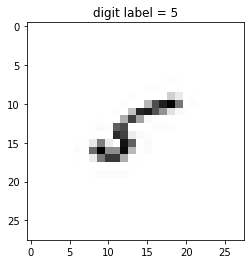

In [13]:
# Display the hand-written digit-
plt.imshow(example_element['pixels'].numpy(), cmap = 'gray', aspect = 'equal')

plt.title(f"digit label = {example_element['label'].numpy()}")
# plt.grid(False)
plt.show()

### Exploring heterogeneity in federated data:

_Federated data is typically non-i.i.d._, __users typically have different distributions of data depending on usage patterns__. _Some clients may have fewer training examples on device, suffering from data paucity locally, while some clients will have more than enough training examples_.

Let's explore this concept of data heterogeneity typical of a federated system with the EMNIST data we have with us. _It's important to note that this deep analysis of a client's data is only available to us because this is a simulation environment where all the data is available to us locally_. __In a real production federated environment you would not be able to inspect a single client's data__.

First, let's get a sampling of one client's data to get a feel for the examples on one simulated device. Because the dataset we're using has been keyed by a unique writer, the data of one client represents the handwriting of one person for a sample of the digits 0 through 9, simulating the unique "usage pattern" of one user.

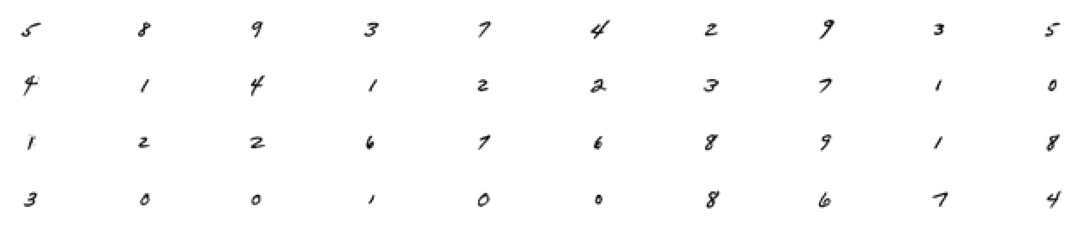

In [14]:
# Example MNIST digits for just one client-
figure = plt.figure(figsize = (20, 4))

j = 0

for example in example_dataset.take(40):
    plt.subplot(4, 10, j + 1)
    plt.imshow(example['pixels'].numpy(), cmap = 'gray', aspect = 'equal')
    plt.axis('off')
    j += 1


### More visualizations:

Next, we _visualize the (total) number of examples on each of the client for each MNIST digit label_. __In the federated environment, the number of examples on each client can vary quite a bit, depending on user behavior__.

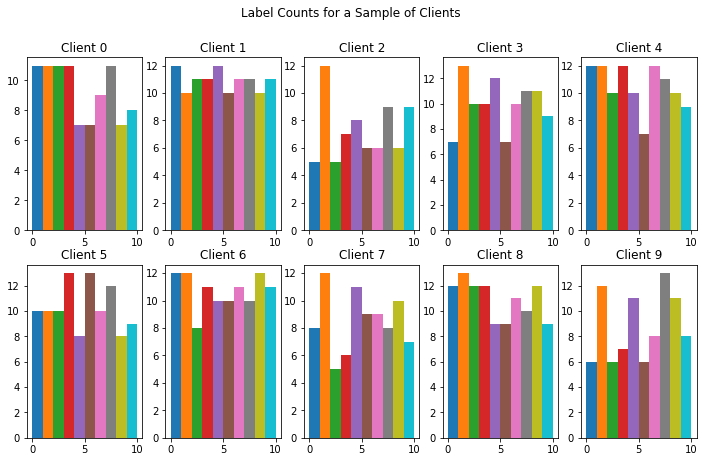

In [15]:
# Number of examples per client for a sample of clients (in this example, there are 10 clients)-
f = plt.figure(figsize = (12, 7))
f.suptitle('Label Counts for a Sample of Clients')

for i in range(10):
    client_dataset = emnist_train.create_tf_dataset_for_client(emnist_train.client_ids[i])
    plot_data = collections.defaultdict(list)

    for example in client_dataset:
        # Append counts individually per label to make plots
        # more colorful instead of one color per plot.
        label = example['label'].numpy()
        plot_data[label].append(label)
    
    plt.subplot(2, 5, i+1)
    plt.title('Client {}'.format(i))
    
    for j in range(10):
        plt.hist(
            plot_data[j], density=False,
            bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        )


We now _visualize the mean image per client for each MNIST label_. This code will produce _the mean of each pixel value for all of the user's examples for one label_.

- We'll see that __one client's mean image for a digit will look different than another client's mean image for the same digit, due to each person's unique handwriting style__.

- We can muse about __how each local training round will nudge the model in a different direction on each client, as we're learning from that user's own unique data in that local round__.

- Later in the tutorial we'll see __how we can take each update to the model from all the clients and aggregate them together into our new global model, that has learned from each of our client's own unique data__.

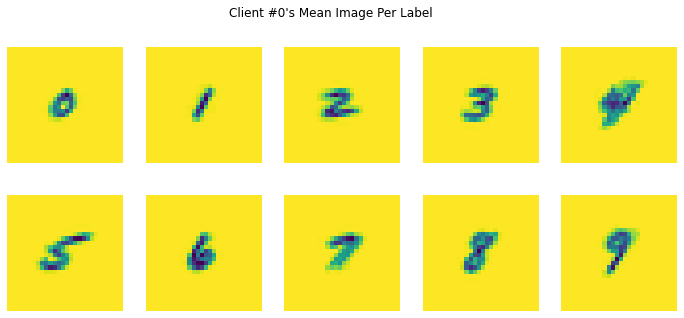

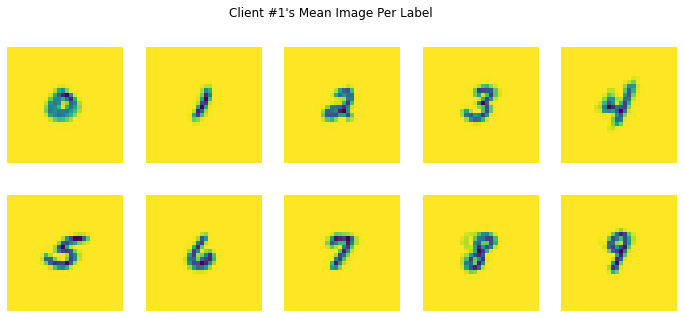

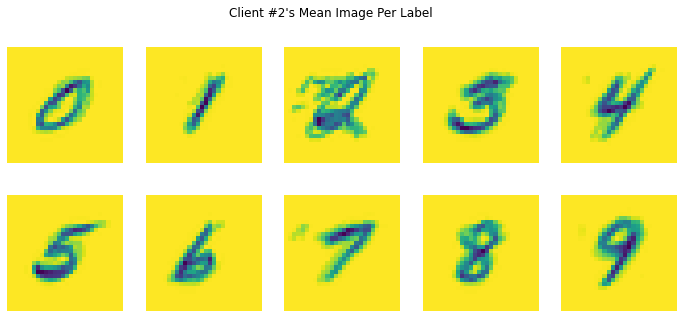

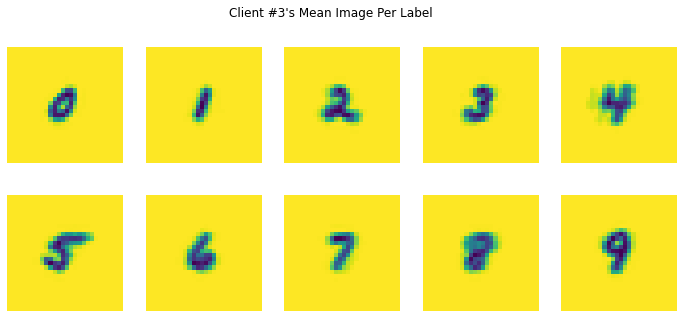

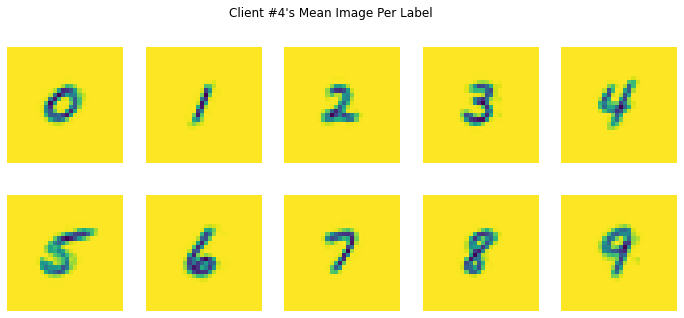

In [16]:
# Each client has different mean images, meaning each client will be nudging the model in their own directions locally-
for i in range(5):
    client_dataset = emnist_train.create_tf_dataset_for_client(emnist_train.client_ids[i])
    plot_data = collections.defaultdict(list)
    
    for example in client_dataset:
        plot_data[example['label'].numpy()].append(example['pixels'].numpy())
  
    f = plt.figure(i, figsize=(12, 5))
    f.suptitle("Client #{}'s Mean Image Per Label".format(i))
    
    for j in range(10):
        mean_img = np.mean(plot_data[j], 0)
        plt.subplot(2, 5, j+1)
        plt.imshow(mean_img.reshape((28, 28)))
        plt.axis('off')


User data can be noisy and unreliably labeled. For example, looking at Client number 2's data above, we can see that for label 2, it is possible that there may have been some mislabeled examples creating a noisier mean image.

### Preprocessing the input data:

Since the data is already a [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), preprocessing can be accomplished by using Dataset transformations consisting of:

- We flatten the 28 x 28 images into 784-element 1-D arrays
- Shuffle the individual examples
- Organize them into batches
- (and) Rename the features from pixels and label to x and y for use with Keras.

We also throw in a repeat over the data set to run several epochs.

In [19]:
NUM_CLIENTS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):

    def batch_format_fn(element):
        """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
        return collections.OrderedDict(
            x = tf.reshape(element['pixels'], [-1, 784]),
            y = tf.reshape(element['label'], [-1, 1])
        )

    return dataset.repeat(NUM_EPOCHS).shuffle(
        SHUFFLE_BUFFER).batch(BATCH_SIZE).map(
        batch_format_fn).prefetch(PREFETCH_BUFFER)


In [20]:
# Sanity check-
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

In [24]:
type(sample_batch), sample_batch.keys()

(collections.OrderedDict, odict_keys(['x', 'y']))

In [25]:
sample_batch['x'].shape, sample_batch['y'].shape

((20, 784), (20, 1))

We have almost all of the building blocks in place to construct federated data sets.

__One of the ways to feed federated data to TFF in a simulation is simply as a Python list, with each element of the list holding the data of an individual user, whether as a list or as a tf.data.Dataset__. Since we already have an interface that provides the latter (tf.data.Dataset), let's use it.

Here's a simple helper function that will construct a list of datasets from the given set of users as an input to a round of training or evaluation.

In [26]:
def make_federated_data(client_data, client_ids):
    return [
        preprocess(client_data.create_tf_dataset_for_client(x)) for x in client_ids
    ]


### How do we choose clients?

In a typical federated training scenario, we are dealing with potentially a very large population of user devices from which only a fraction may be available for training at a given point in time. This is the case, for example, when the client devices are mobile phones that participate in training only when plugged into a power source, off a metered network (or using Wi-Fi), and otherwise idle.

Of course, we are in a simulation environment, and all of the data is locally available. Typically then, __when running simulations, we would simply sample a random subset of the clients to be involved in each round of training, generally different in each round__.

That said, as you can find out by studying the paper on the [Federated Averaging](https://arxiv.org/abs/1602.05629) algorithm, __achieving convergence in a system with randomly sampled subsets of clients in each round can take a while__, and it would be impractical to have to run hundreds of rounds in this interactive tutorial.

_What we will do instead is sample the set of clients once, and reuse the same set across rounds to speed up convergence (intentionally over-fitting to these few user's data)_. We leave it as an exercise for the reader to modify this tutorial to simulate random sampling - it is fairly easy to do (once you do, keep in mind that getting the model to converge may take a while).

In [30]:
sample_clients = emnist_train.client_ids[0 : NUM_CLIENTS]  # returns client-ids

federated_train_data = make_federated_data(emnist_train, sample_clients)
# 'federated_train_data' is a list

In [36]:
print(f"number of client datasets chosen = {len(federated_train_data)}")
print(f"\nfirst dataset: {federated_train_data[0]}")

number of client datasets chosen = 10

first dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


### Creating a model with Keras:

Apart from this defined model below, you can also create a LeNet-300-100 dense neural networks for (hopefully) better results.

In [40]:
def create_keras_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(784,)),
        tf.keras.layers.Dense(10, kernel_initializer='zeros'),
        tf.keras.layers.Softmax(),
    ])


In [39]:
def lenet300():
    model = tf.keras.models.Sequential()
    
    model.add(
        tf.keras.layers.Input(shape = (784, ))
    )
    
    model.add(
        tf.keras.layers.Dense(
            units = 300, activation = tf.nn.relu,
            kernel_initializer='glorot_normal',
            bias_initializer = 'ones'
        ) 
    )
    
    model.add(
        tf.keras.layers.Dense(
            units = 100, activation = tf.nn.relu,
            kernel_initializer='glorot_normal',
            bias_initializer = 'ones'
        ) 
    )
    
    model.add(
        tf.keras.layers.Softmax()
    )
    
    return model


### Note: we do not compile the defined model yet. The loss, metrics, and optimizers are introduced later.

### Creating a neural network model with _Keras_:

In order to use any model with TFF, it needs to be wrapped in an instance of the [tff.learning.Model](https://www.tensorflow.org/federated/api_docs/python/tff/learning/Model) interface, which exposes methods to stamp the model's forward pass, metadata properties, etc., similar to Keras, but also introduces additional elements, such as ways to control the process of computing federated metrics.

Let's not worry about this for now; if you have a Keras model like the one we've just defined above, you can have TFF wrap it for you by invoking [tff.learning.from_keras_model](https://www.tensorflow.org/federated/api_docs/python/tff/learning/from_keras_model), passing the model and a sample data batch as arguments, as shown below-

In [42]:
def model_fn():
    # We "must" create a new model here, and "not" capture it from an external
    # scope. TFF will call this from within different graph contexts.
    keras_model = create_keras_model()
    # OR-
    # keras_model = lenet300()
    
    return tff.learning.from_keras_model(
        keras_model,
        input_spec = preprocessed_example_dataset.element_spec,
        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()
                ]
    )


### Training the model on federated data:

Now that we have a model wrapped as [tff.learning.Model](https://www.tensorflow.org/federated/api_docs/python/tff/learning/Model) for use with TFF, we can let TFF construct a Federated Averaging algorithm by invoking the helper function [tff.learning.build_federated_averaging_process](https://www.tensorflow.org/federated/api_docs/python/tff/learning/build_federated_averaging_process), as follows.

Keep in mind that the argument needs to be a constructor (such as ```model_fn()``` above), not an already-constructed instance, so that the construction of your model can happen in a context controlled by TFF (if you're curious about the reasons for this, we encourage you to read the follow-up tutorial on [custom algorithms](https://www.tensorflow.org/federated/tutorials/custom_federated_algorithms_1)).

__NOTE:__ For Federated Averaging algorithm shown below, there are two optimizers:

- a _client optimizer_ which is used only to compute local model updates for each client

- a _server optimizer_ which applies the averaged update to the global model present at the server


In particular, this means that __the choice of optimizer and learning rate used may need to be different than the ones you have used to train the model on a standard i.i.d. dataset__. _We recommend starting with regular SGD, possibly with a smaller learning rate than usual_. The learning rate used here has not been carefully tuned and may be further experimented with.

In [44]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn = model_fn,
    client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate = 0.02),
    server_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate = 1.0)
)

In [ ]:
'''
opt = lambda: tf.keras.optimizers.SGD(learning_rate = 0.01)
print(f"optimizer: {opt()}")
# optimizer: <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fdcbce7b3a0>
'''

TFF has constructed a pair of _federated computations_ and packaged them into a [tff.templates.IterativeProcess](https://www.tensorflow.org/federated/api_docs/python/tff/templates/IterativeProcess) in which these computations are available as a pair of properties ```initialize``` and ```next```.

In a nutshell, _federated computations_ are programs in TFF's internal language that can express various federated algorithms (you can find more about this in the [custom algorithms](https://www.tensorflow.org/federated/tutorials/custom_federated_algorithms_1) tutorial). In this case, the two computations generated and packed into ```iterative_process``` implement [Federated Averaging](https://arxiv.org/abs/1602.05629).

__It is a goal of TFF to define computations in a way so that they could be executed in real federated learning settings, but currently only local execution simulation runtime is implemented__. _To execute a computation in a simulator, you simply invoke it like a Python function. This default interpreted environment is not designed for high performance, but it will suffice for this tutorial; we expect to provide higher-performance simulation runtimes to facilitate larger-scale research in future releases_.

Let's start with the ```initialize``` computation. As is the case for all federated computations, __you can think of it ```initialize``` as a function. The computation takes no arguments, and returns one result - the representation of the state of the Federated Averaging process on the server__. While we don't want to dive into the details of TFF, it may be instructive to see what this state looks like. You can visualize it as follows-

In [51]:
str(iterative_process.initialize.type_signature)

'( -> <model=<trainable=<float32[784,10],float32[10]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<value_sum_process=<>,weight_sum_process=<>>,model_broadcast_state=<>>@SERVER)'

While the above type signature may at first seem a bit cryptic, you can recognize that the server state consists of a ```model``` (the initial model parameters for MNIST that will be distributed to all devices), and ```optimizer_state``` (additional information maintained by the server, such as the number of rounds to use for hyperparameter schedules, etc.).

In [52]:
# Let's invoke the 'initialize' computation to construct the server state-
state = iterative_process.initialize()

The second of the pair of federated computations, ```next```, represents a single round of Federated Averaging, which consists of pushing the server state (including the model parameters) to the clients, on-device training on their local data, collecting and averaging model updates, and producing a new updated model at the server.

Conceptually, you can think of ```next``` as having a functional type signature that looks as follows-

SERVER_STATE, FEDERATED_DATA -> SERVER_STATE, TRAINING_METRICS

In particular, one should think about ```next()``` not as being a function that runs on a server, but rather being a declarative functional representation of the entire decentralized computation - some of the inputs are provided by the server (```SERVER_STATE```), but each participating device contributes its own local dataset.

Let's run a single round of training and visualize the results. We can use the federated data we've already generated above for a sample of users.

In [53]:
state, metrics = iterative_process.next(state, federated_train_data)
print(f"round: 1, metrics = {metrics}")

round: 1, metrics = OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.12592593), ('loss', 3.0727448)])), ('stat', OrderedDict([('num_examples', 4860)]))])


In [62]:
# 'metrics' is a nested 'OrderedDict'. Only print for keys having an object inside-
for metric_key in metrics.keys():
    # print(metric_key)
    if metrics[metric_key]:
        print(metrics[metric_key])

OrderedDict([('mean_value', ()), ('mean_weight', ())])
OrderedDict([('sparse_categorical_accuracy', 0.12592593), ('loss', 3.0727448)])
OrderedDict([('num_examples', 4860)])


Let's run a few more rounds. As noted earlier, __typically at this point you would pick a subset of your simulation data from a new randomly selected sample of users for each round in order to simulate a realistic deployment in which users continuously come and go__, but in this interactive notebook, for the sake of demonstration we'll just reuse the same users, so that the system converges quickly.

In [63]:
NUM_ROUNDS = 11

for round_num in range(2, NUM_ROUNDS):
    state, metrics = iterative_process.next(state, federated_train_data)
    print(f"round = {round_num}, metrics = {metrics}")

round = 2, metrics = OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.13518518), ('loss', 2.9155476)])), ('stat', OrderedDict([('num_examples', 4860)]))])
round = 3, metrics = OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.14773662), ('loss', 2.7923265)])), ('stat', OrderedDict([('num_examples', 4860)]))])
round = 4, metrics = OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.18209876), ('loss', 2.6560438)])), ('stat', OrderedDict([('num_examples', 4860)]))])
round = 5, metrics = OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.20699589), ('

Training loss is decreasing after each round of federated training, indicating the model is converging. There are some important caveats with these training metrics, however, see the section on _Evaluation_ later in this tutorial.

### Displaying model metrics in TensorBoard:

Next, let's visualize the metrics from these federated computations using Tensorboard.

In [ ]:
# Uncomment and run this this cell to clean your directory of old output for
# future graphs from this directory. We don't run it by default so that if 
# you do a "Runtime > Run all" you don't lose your results.

# !rm -R /tmp/logs/scalars/*

In [64]:
# start by creating the directory and the corresponding summary writer to write the metrics to-
logdir = "/home/arjun/Deep_Learning_Resources/Federated_Learning-Resources/Jupyter-Notebooks_and_Codes/scalars/training/"
summary_writer = tf.summary.create_file_writer(logdir)

state = iterative_process.initialize()

# In order to view evaluation metrics the same way, you can create a separate eval folder, like "*/scalars/eval", to write to TensorBoard.

In [65]:
# Plot the relevant scalar metrics with the same summary writer-
with summary_writer.as_default():
    for round_num in range(1, NUM_ROUNDS):
        state, metrics = iterative_process.next(state, federated_train_data)
        for name, value in metrics['train'].items():
            tf.summary.scalar(name, value, step = round_num)


In [67]:
# Start TensorBoard with the directory specified above. It can take a few seconds for the data to load-
!ls {logdir}
%tensorboard --logdir {logdir} --port=0

events.out.tfevents.1618916379.Markovian.3253.13764.v2


### Customizing the model implementation:

Keras is the [recommended high-level model API for TensorFlow](https://medium.com/tensorflow/standardizing-on-keras-guidance-on-high-level-apis-in-tensorflow-2-0-bad2b04c819a), and we encourage using Keras models (via [tff.learning.from_keras_model](https://www.tensorflow.org/federated/api_docs/python/tff/learning/from_keras_model)) in TFF whenever possible.

However, [tff.learning](https://www.tensorflow.org/federated/api_docs/python/tff/learning) provides a lower-level model interface, [tff.learning.Model](https://www.tensorflow.org/federated/api_docs/python/tff/learning/Model), that exposes the minimal functionality necessary for using a model for federated learning. Directly implementing this interface (possibly still using building blocks like [tf.keras.layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers)) allows for maximum customization without modifying the internals of the federated learning algorithms.

So let's do it all over again from scratch.


### Defining model variables, forward pass, and metrics:

The first step is to identify the TensorFlow variables we're going to work with. In order to make the following code more legible, let's define a data structure to represent the entire set. This will include variables such as``` weights``` and ```bias``` that we will train, as well as variables that will hold various cumulative statistics and counters we will update during training, such as ```loss_sum```, ```accuracy_sum```, and ```num_examples```.

In [68]:
MnistVariables = collections.namedtuple('MnistVariables', 'weights bias num_examples loss_sum accuracy_sum')

Here's a method that creates the variables. For the sake of simplicity, we represent all statistics as tf.float32, as that will eliminate the need for type conversions at a later stage. Wrapping variable initializers as lambdas is a requirement imposed by [resource variables](https://www.tensorflow.org/api_docs/python/tf/enable_resource_variables).

In [75]:
def create_mnist_variables():
    return MnistVariables(
        weights=tf.Variable(
            lambda: tf.zeros(dtype = tf.float32, shape = (784, 10)),
            name = 'weights', trainable = True),
        
        bias=tf.Variable(
            lambda: tf.ones(dtype = tf.float32, shape = (10)),
            name= 'bias', trainable = True),
        
        num_examples=tf.Variable(0.0, name = 'num_examples', trainable = False),
        loss_sum = tf.Variable(0.0, name = 'loss_sum', trainable = False),
        accuracy_sum = tf.Variable(0.0, name = 'accuracy_sum', trainable = False))


With the variables for model parameters and cumulative statistics in place, we can now define the forward pass method that computes loss, makes predictions, and updates the cumulative statistics for a single batch of input data, as follows-

In [76]:
def mnist_forward_pass(variables, batch):
    y = tf.nn.softmax(tf.matmul(batch['x'], variables.weights) + variables.bias)
    predictions = tf.cast(tf.argmax(y, 1), tf.int32)

    flat_labels = tf.reshape(batch['y'], [-1])
    
    loss = -tf.reduce_mean(tf.reduce_sum(tf.one_hot(flat_labels, 10) * tf.math.log(y), axis=[1]))
    
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, flat_labels), tf.float32))

    num_examples = tf.cast(tf.size(batch['y']), tf.float32)

    variables.num_examples.assign_add(num_examples)
    variables.loss_sum.assign_add(loss * num_examples)
    variables.accuracy_sum.assign_add(accuracy * num_examples)

    return loss, predictions


Next, we define a function that returns a set of local metrics, again using TensorFlow. These are the values (in addition to model updates, which are handled automatically) that are eligible to be aggregated to the server in a federated learning or evaluation process.

Here, we simply return the average ```loss``` and ```accuracy```, as well as the ```num_examples```, which we'll need to correctly weight the contributions from different users when computing federated aggregates.

In [77]:
def get_local_mnist_metrics(variables):
    return collections.OrderedDict(
        num_examples = variables.num_examples,
        loss = variables.loss_sum / variables.num_examples,
        accuracy = variables.accuracy_sum / variables.num_examples)


Finally, we need to determine how to aggregate the local metrics emitted by each device via ```get_local_mnist_metrics```. This is the only part of the code that isn't written in TensorFlow - it's a _federated computation_ expressed in TFF. If you'd like to dig deeper, skim over the [custom algorithms](https://www.tensorflow.org/federated/tutorials/custom_federated_algorithms_1) tutorial, but in most applications, you won't really need to; variants of the pattern shown below should suffice. Here's what it looks like-

In [78]:
@tff.federated_computation
def aggregate_mnist_metrics_across_clients(metrics):
    return collections.OrderedDict(
        num_examples = tff.federated_sum(metrics.num_examples),
        loss = tff.federated_mean(metrics.loss, metrics.num_examples),
        accuracy = tff.federated_mean(metrics.accuracy, metrics.num_examples)
    )


The input ```metrics``` argument corresponds to the ```OrderedDict``` returned by ```get_local_mnist_metrics``` above, but critically the values are no longer ```tf.Tensors``` - they are "boxed" as [tff.Value](https://www.tensorflow.org/federated/api_docs/python/tff/Value)s, to make it clear you can no longer manipulate them using TensorFlow, but only using TFF's federated operators like [tff.federated_mean](https://www.tensorflow.org/federated/api_docs/python/tff/federated_mean) and [tff.federated_sum](https://www.tensorflow.org/federated/api_docs/python/tff/federated_sum). The returned dictionary of global aggregates defines the set of metrics which will be available on the server.

### Constructing an instance of [tff.learning.Model](https://www.tensorflow.org/federated/api_docs/python/tff/learning/Model)

With all of the above in place, we are ready to construct a model representation for use with TFF similar to one that's generated for you when you let TFF ingest a Keras model.

In [79]:
class MnistModel(tff.learning.Model):

    def __init__(self):
        self._variables = create_mnist_variables()

    @property
    def trainable_variables(self):
        return [self._variables.weights, self._variables.bias]

    @property
    def non_trainable_variables(self):
        return []

    @property
    def local_variables(self):
        return [
            self._variables.num_examples, self._variables.loss_sum,
            self._variables.accuracy_sum
        ]

    @property
    def input_spec(self):
        return collections.OrderedDict(
            x = tf.TensorSpec([None, 784], tf.float32),
            y = tf.TensorSpec([None, 1], tf.int32))

    @tf.function
    def forward_pass(self, batch, training=True):
        del training
        loss, predictions = mnist_forward_pass(self._variables, batch)
        num_exmaples = tf.shape(batch['x'])[0]
        return tff.learning.BatchOutput(
            loss = loss, predictions = predictions, num_examples = num_exmaples
        )

    @tf.function
    def report_local_outputs(self):
        return get_local_mnist_metrics(self._variables)

    @property
    def federated_output_computation(self):
        return aggregate_mnist_metrics_across_clients
    

As you can see, the abstract methods and properties defined by [tff.learning.Model](https://www.tensorflow.org/federated/api_docs/python/tff/learning/Model) corresponds to the code snippets in the preceding section that introduced the variables and defined the loss and statistics.

Here are a few points worth highlighting:

- All state that your model will use must be captured as TensorFlow variables, as TFF does not use Python at runtime (remember your code should be written such that it can be deployed to mobile devices; see the [custom algorithms](https://www.tensorflow.org/federated/tutorials/custom_federated_algorithms_1) tutorial for a more in-depth commentary on the reasons).

- Your model should describe what form of data it accepts (```input_spec```), as in general, TFF is a strongly-typed environment and wants to determine type signatures for all components. Declaring the format of your model's input is an essential part of it.

- Although technically not required, we recommend wrapping all TensorFlow logic (forward pass, metric calculations, etc.) as [tf.function](https://www.tensorflow.org/api_docs/python/tf/function)s, as this helps ensure the TensorFlow can be serialized, and removes the need for explicit control dependencies.

The above is sufficient for evaluation and algorithms like Federated SGD. However, for Federated Averaging, we need to specify how the model should train locally on each batch. We will specify a local optimizer when building the Federated Averaging algorithm.

### Simulating federated training with the new model:

With all of the above in place, the remainder of the process looks like what we've seen already - just replace the model constructor with the constructor of our new model class, and use the two federated computations in the iterative process you created to cycle through training rounds.

In [80]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn = MnistModel,
    client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate = 0.02))

In [81]:
state = iterative_process.initialize()

state, metrics = iterative_process.next(state, federated_train_data)
print(f"round: 1, metrics = {metrics}")

round: 1, metrics = OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('num_examples', 4860.0), ('loss', 3.0716066), ('accuracy', 0.123662554)])), ('stat', OrderedDict([('num_examples', 4860)]))])


In [84]:
for round_num in range(2, 11):
    state, metrics = iterative_process.next(state, federated_train_data)
    print(f"round {round_num:2d}, metrics = {metrics}")

round  2, metrics = OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('num_examples', 4860.0), ('loss', 2.9102974), ('accuracy', 0.1479424)])), ('stat', OrderedDict([('num_examples', 4860)]))])
round  3, metrics = OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('num_examples', 4860.0), ('loss', 2.753225), ('accuracy', 0.17345679)])), ('stat', OrderedDict([('num_examples', 4860)]))])
round  4, metrics = OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('num_examples', 4860.0), ('loss', 2.6044235), ('accuracy', 0.19115226)])), ('stat', OrderedDict([('num_examples', 4860)]))])
round  5, metrics = OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('num_examples', 4860.0), ('loss

### Evaluation:

All of our experiments so far presented only federated training metrics - the average metrics over all batches of data trained across all clients in the round. This introduces the normal concerns about overfitting, especially since we used the same set of clients on each round for simplicity, __but there is an additional notion of overfitting in training metrics specific to the Federated Averaging algorithm. This is easiest to see if we imagine each client had a single batch of data, and we train on that batch for many iterations (epochs). In this case, the local model will quickly exactly fit to that one batch, and so the local accuracy metric we average will approach 1.0. Thus, these training metrics can be taken as a sign that training is progressing, but not much more__.

To perform evaluation on federated data, you can construct another _federated computation_ designed for just this purpose, using the [tff.learning.build_federated_evaluation](https://www.tensorflow.org/federated/api_docs/python/tff/learning/build_federated_evaluation) function, and passing in your model constructor as an argument. Note that unlike with Federated Averaging, where we've used ```MnistTrainableModel```, it suffices to pass the ```MnistModel```. Evaluation doesn't perform gradient descent, and there's no need to construct optimizers.

For experimentation and research, when a centralized test dataset is available, [Federated Learning for Text Generation](https://www.tensorflow.org/federated/tutorials/federated_learning_for_text_generation) demonstrates another evaluation option: taking the trained weights from federated learning, applying them to a standard Keras model, and then simply calling [tf.keras.models.Model.evaluate()](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate) on a centralized dataset.

In [85]:
evaluation = tff.learning.build_federated_evaluation(MnistModel)

In [86]:
# You can inspect the abstract type signature of the evaluation function as follows-
str(evaluation.type_signature)

'(<server_model_weights=<trainable=<float32[784,10],float32[10]>,non_trainable=<>>@SERVER,federated_dataset={<x=float32[?,784],y=int32[?,1]>*}@CLIENTS> -> <num_examples=float32@SERVER,loss=float32@SERVER,accuracy=float32@SERVER>)'

No need to be concerned about the details at this point, just be aware that it takes the following general form, similar to [tff.templates.IterativeProcess.next](https://www.tensorflow.org/federated/api_docs/python/tff/templates/IterativeProcess#next) but with two important differences:

- First, we are not returning server state, since evaluation doesn't modify the model or any other aspect of state - you can think of it as stateless. 

- Second, evaluation only needs the model, and doesn't require any other part of server state that might be associated with training, such as optimizer variables.

SERVER_MODEL, FEDERATED_DATA -> TRAINING_METRICS

Let's invoke evaluation on the latest state we arrived at during training. In order to extract the latest trained model from the server state, you simply access the ```.model``` member, as follows-

In [87]:
train_metrics = evaluation(state.model, federated_train_data)

Here's what we get. Note the numbers look marginally better than what was reported by the last round of training above. By convention, the training metrics reported by the iterative training process generally reflect the performance of the model at the beginning of the training round, so the evaluation metrics will always be one step ahead.

In [88]:
# Evaluation metrics will always be one step ahead-
str(train_metrics)

"OrderedDict([('num_examples', 4860.0), ('loss', 1.5173337), ('accuracy', 0.5946502)])"

In [90]:
# Now, let's compile a test sample of federated data and rerun evaluation on the test data. The data will come from the same sample of real
# users, but from a distinct held-out data set-
federated_test_data = make_federated_data(emnist_test, sample_clients)

len(federated_test_data), federated_test_data[0]

(10,
 <PrefetchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>)

In [91]:
test_metrics = evaluation(state.model, federated_test_data)
str(test_metrics)

"OrderedDict([('num_examples', 580.0), ('loss', 1.6316314), ('accuracy', 0.5344828)])"

This concludes the tutorial. We encourage you to play with the parameters like: batch size, number of users, epochs, learning rates, etc., to modify the code above to simulate training on random samples of users in each round, and to explore the other tutorials.